In [3]:
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm #color maps
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [27]:
features = pd.read_csv('cc-features.csv')

features.head()

,date,Weekday,WeekdayNum,AvgHintLength,AvgAnswerLength,NumHints,NumOneWordHints,BlockDensity,OtherPuzAns,PctPNC,PctWP
0,1994-01-01,Saturday,5,14.969697,5.666667,66,15,16.888889,3093,18.181818,4.545455
1,1994-01-02,Sunday,6,15.547059,4.976471,170,33,20.037807,11874,20.588235,6.470588
2,1994-01-03,Monday,0,13.368421,4.815789,76,16,18.666667,6770,26.315789,2.631579
3,1994-01-04,Tuesday,1,14.602564,4.846154,78,13,16.000000,6572,20.512821,6.410256
4,1994-01-05,Wednesday,2,13.312500,4.675000,80,24,16.888889,6352,22.500000,1.250000


In [30]:
X = features[['BlockDensity','OtherPuzAns','AvgAnswerLength','PctWP','PctPNC']].to_numpy()
y = features[['WeekdayNum']].to_numpy()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 666, 
                                                    shuffle=True,
                                                    stratify=y)

## cross-validation for max depth

In [21]:
# n will be the maximum max_depth I consider
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=440)
n = 10

accs = np.zeros((5,n))
precs = np.zeros((5,n))
recs = np.zeros((5,n))

for j in range(1,n+1):
    print("iteration ",j)
    rf = RandomForestClassifier(n_estimators = 500, max_depth=j, random_state=617)
    i=0
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_train, X_train_test = X_train[train_index], X_train[test_index]
        y_train_train, y_train_test = y_train[train_index], y_train[test_index]
        
        rf_clone = clone(rf)
        rf_clone.fit(X_train_train,y_train_train.ravel())
        
        y_predict = rf_clone.predict(X_train_test)
        accs[i,j-1] = accuracy_score(y_train_test,y_predict)
        precs[i,j-1] = precision_score(y_train_test,y_predict,average='weighted',zero_division=0)
        recs[i,j-1] = recall_score(y_train_test,y_predict,average='weighted',zero_division=0)
        i = i + 1

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10


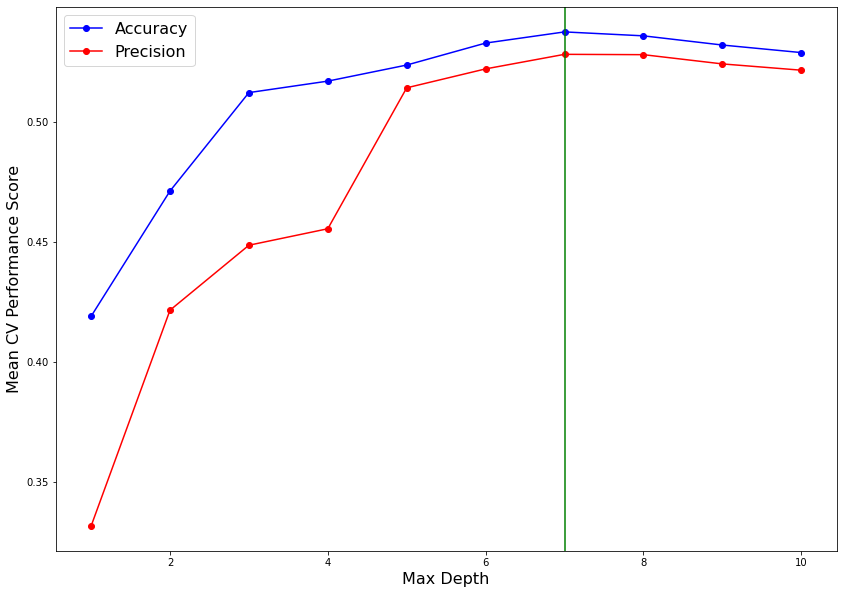

In [44]:
best_depth = np.argmax(np.mean(accs, axis=0))+1
plt.figure(figsize=(14,10))

plt.plot(range(1,n+1), np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), np.mean(precs,axis=0),'r-o', label="Precision")
#plt.plot(range(1,n+1), np.mean(recs,axis=0),'g-o', label="Recall")
plt.axvline(x=best_depth, color='g')

plt.ylabel("Mean CV Performance Score",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)

plt.legend(fontsize=16)

plt.show()

In [23]:
print(f"The highest accuraccy is in the model with a max depth of {best_depth}.")

The highest accuraccy is in the model with a max depth of 7.


In [42]:
accs
np.mean(accs,axis=0)

array([0.41902455, 0.47122977, 0.51223215, 0.51701506, 0.52371269,
       0.53286812, 0.53751629, 0.53587602, 0.5320492 , 0.52890516])

## details on best model

In [45]:
rf_f = RandomForestClassifier(max_depth=best_depth, random_state=617)
rf_f.fit(X_train,y_train.ravel())

RandomForestClassifier(max_depth=7, random_state=617)

In [51]:
#performance on test data

y_pred = rf_f.predict(X_test)
f_acc = accuracy_score(y_test,y_pred)
f_prec = precision_score(y_test,y_pred,average='micro')
f_rec = recall_score(y_test,y_pred,average='micro')
print(f"Overall scores:")
print(f"Accuracy:\t{np.round(f_acc*100,2)}%")
print(f"Precision:\t{np.round(f_prec*100,2)}%")
print(f"Recall:\t\t{np.round(f_rec*100,2)}%")



Overall scores:
Accuracy:	53.98%
Precision:	53.98%
Recall:		53.98%


(2440,)

In [55]:
class_labels = features.groupby(['WeekdayNum','Weekday']).size().reset_index()['Weekday'].tolist()
class_labels

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

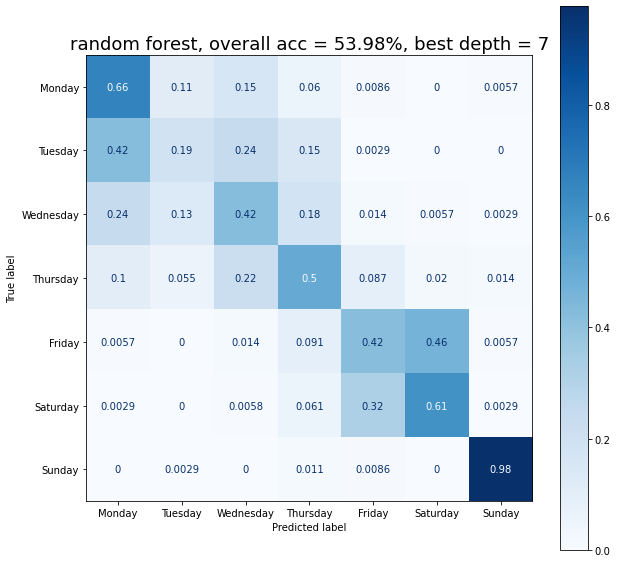

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(rf_f, X_test, y_test, 
                      display_labels=class_labels,
                      ax=ax, 
                      normalize='true',
                      cmap=cm.get_cmap('Blues'))
ax.set_title(f"random forest, overall acc = {np.round(f_acc*100,2)}%, best depth = {best_depth}", fontsize=18)
plt.show()